<a href="https://colab.research.google.com/github/MH-1294/ML_DL/blob/main/CRAT_Adversarial_Attack!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dmmehedihasanabid_cityscapes_leftimg_trainvaltest_gt_trainvaltest_path = kagglehub.dataset_download('dmmehedihasanabid/cityscapes-leftimg-trainvaltest-gt-trainvaltest')

print('Data source import complete.')


# Block 0: Install + Import

In [ ]:
# ----------- Install (Kaggle-safe) -----------
!pip install --quiet cityscapesscripts

# ----------- Core Imports -----------
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ----------- PyTorch -----------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------- torchvision -----------
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode


# Block 1: Custom Dataset with Safe Resize & Tensor Conversion

In [ ]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx])  # assumes labelId PNG

        # Resize (image = bilinear, label = nearest)
        image = TF.resize(image, size=(512, 1024), interpolation=InterpolationMode.BILINEAR)
        label = TF.resize(label, size=(512, 1024), interpolation=InterpolationMode.NEAREST)

        # Convert to tensor
        image = TF.to_tensor(image)
        label = torch.as_tensor(np.array(label), dtype=torch.long)

        # Clamp labels to model-supported range [0, 18] to prevent crash
        label = torch.clamp(label, 0, 18)


        return image, label

    def __len__(self):
        return len(self.image_paths)


# Restore Session

In [ ]:
import json, os
from collections import defaultdict

# Global store: RESULTS[model_name]['clean' or 'adv'][region] = miou
RESULTS = defaultdict(lambda: {'clean': {}, 'adv': {}})

SAVE_JSON = "/kaggle/working/crat_results.json"

def save_results():
    with open(SAVE_JSON, "w") as f:
        json.dump(RESULTS, f, indent=2)
    print(f"Saved metrics to {SAVE_JSON}")

def load_results():
    global RESULTS
    if os.path.exists(SAVE_JSON):
        with open(SAVE_JSON, "r") as f:
            RESULTS = defaultdict(lambda: {'clean': {}, 'adv': {}},
                                  json.load(f))
        print(f"Loaded metrics from {SAVE_JSON}")


# Block 2: Dataset & DataLoader Setup

In [ ]:
# ----------- Paths -----------
root_dir = "/kaggle/input/cityscapes-leftimg-trainvaltest-gt-trainvaltest/Cityscapes"
image_dir = os.path.join(root_dir, "leftImg8bit")
label_dir = os.path.join(root_dir, "gtFine")

# ----------- Utility: Collect paths -----------
def collect_image_label_paths(split):
    img_paths = []
    lbl_paths = []
    split_img_dir = os.path.join(image_dir, split)
    split_lbl_dir = os.path.join(label_dir, split)

    for city in os.listdir(split_img_dir):
        img_city_dir = os.path.join(split_img_dir, city)
        lbl_city_dir = os.path.join(split_lbl_dir, city)

        for filename in os.listdir(img_city_dir):
            if filename.endswith("_leftImg8bit.png"):
                img_path = os.path.join(img_city_dir, filename)
                lbl_filename = filename.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                lbl_path = os.path.join(lbl_city_dir, lbl_filename)

                if os.path.exists(lbl_path):
                    img_paths.append(img_path)
                    lbl_paths.append(lbl_path)

    return img_paths, lbl_paths

# ----------- Build datasets -----------
train_img_paths, train_lbl_paths = collect_image_label_paths("train")
val_img_paths, val_lbl_paths = collect_image_label_paths("val")

train_dataset = CityscapesDataset(train_img_paths, train_lbl_paths)
val_dataset = CityscapesDataset(val_img_paths, val_lbl_paths)

# ----------- DataLoaders -----------
trainloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True   #
)
valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

# ----------- Debug: Check one batch -----------
sample_images, sample_labels = next(iter(trainloader))
print("Sample image shape:", sample_images.shape)
print("Sample label shape:", sample_labels.shape)


Sample image shape: torch.Size([2, 3, 512, 1024])
Sample label shape: torch.Size([2, 512, 1024])


#  Block 3 — Model Loading (DeepLabv3-ResNet50)

In [ ]:
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50

# ----------- Device -----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device detected:", device)

# ----------- Load Model -----------
model = deeplabv3_resnet50(
    pretrained=False,
    pretrained_backbone=False,
    num_classes=19
)

model = model.to(device)
model.eval()  # Set to eval mode before inference!
print("Model moved to device")

# ----------- Test Forward -----------
x = torch.randn(1, 3, 512, 1024).to(device)
print("Dummy test input created")

with torch.no_grad():
    y = model(x)['out']
    print("Model forward successful, output shape:", y.shape)


Device detected: cuda
Model moved to device
Dummy test input created
Model forward successful, output shape: torch.Size([1, 19, 512, 1024])


# Block 4: fgsm_attack() — Fast Gradient Sign Method (for segmentation)-with Region Masking support

In [ ]:
# ----------- Block 4: Region-Aware FGSM Attack -----------
def fgsm_attack(model, images, labels, epsilon=0.1, region="full"):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)

    outputs = model(images)['out']
    loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Gradient sign
    grad = images.grad.data

    # Region-specific masking
    _, _, H, W = grad.shape
    mask = torch.ones_like(grad)

    if region == "left":
        mask[:, :, :, W // 2:] = 0  # Only apply perturbation to left half
    elif region == "right":
        mask[:, :, :, :W // 2] = 0  # Only apply to right half
    elif region == "center":
        mask[:, :, :, :W // 4] = 0
        mask[:, :, :, 3 * W // 4:] = 0
    elif region == "full":
        pass  # Apply to entire image
    else:
        raise ValueError(f"Unsupported region: {region}")

    # Apply region-aware perturbation
    perturbed_images = images + epsilon * grad.sign() * mask
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images.detach()


# Block 5: train_model() — Full CRAT Training Loop

In [ ]:
def train_model(model, trainloader, epochs=5, epsilon=0.1, lambda_mse=0.5, lambda_channel=0.1, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0.0
        optimizer.zero_grad()
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for step, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device).long()

            # FGSM adversarial image
            adv_images = fgsm_attack(model, images, labels, epsilon=epsilon)

            # Forward: clean and adv
            output_clean = model(images)['out']
            output_adv = model(adv_images)['out']

            # CE loss on both
            loss_clean = F.cross_entropy(output_clean, labels)
            loss_adv = F.cross_entropy(output_adv, labels)

            # AugShift loss: match latent clean/adv
            z_clean = F.adaptive_avg_pool2d(output_clean, (1, 1))
            z_adv = F.adaptive_avg_pool2d(output_adv, (1, 1))
            loss_shift = F.mse_loss(z_clean, z_adv)

            # Total loss
            loss = loss_clean + loss_adv + lambda_mse * loss_shift
            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

            # free memory
            torch.cuda.empty_cache()

            if (step + 1) % 20 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch + 1} complete. Avg Loss: {avg_loss:.4f}")


# Block 6: Evaluation + Visualization

6.1 evaluate_model() — Clean vs. Adversarial Accuracy

In [ ]:
def evaluate_model_and_log(model_name, model, dataloader, epsilon=0.1, region="full", max_batches=500):
    model.eval()
    total_clean, total_adv, n = 0.0, 0.0, 0

    print(f"Running evaluation on {max_batches} batches with region='{region}', eps={epsilon}...")

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device).long()

        # ---- Clean pass (no grad) ----
        with torch.no_grad():
            out_clean = model(images)['out']
            pred_clean = out_clean.argmax(1)

        # ---- Build adversarial images (needs grad!) ----
        images_for_attack = images.clone().detach().requires_grad_(True)
        adv_images = fgsm_attack(model, images_for_attack, labels, epsilon=epsilon, region=region)

        # ---- Adv pass (no grad) ----
        with torch.no_grad():
            out_adv = model(adv_images)['out']
            pred_adv = out_adv.argmax(1)

        # ---- mIoU (simple mask IoU over all pixels != 255) ----
        valid = (labels != 255)
        inter_clean = ((pred_clean == labels) & valid).sum().float()
        union_clean = (valid | (pred_clean == labels)).sum().float()
        iou_clean = inter_clean / (union_clean + 1e-6)

        inter_adv = ((pred_adv == labels) & valid).sum().float()
        union_adv = (valid | (pred_adv == labels)).sum().float()
        iou_adv = inter_adv / (union_adv + 1e-6)

        total_clean += iou_clean.item()
        total_adv  += iou_adv.item()
        n += 1

        if i % 100 == 0:
            print(f"[{i}] Clean IoU: {iou_clean:.4f}, Adv IoU: {iou_adv:.4f}")

        if n >= max_batches:
            break

    print(f"\n{model_name} — Eval Summary (n={n}, region='{region}', eps={epsilon})")
    print(f"Avg Clean mIoU: {total_clean / n:.4f}")
    print(f"Avg Adv   mIoU: {total_adv  / n:.4f}")

6.2 visualize_results() — Display Predictions

In [ ]:
def visualize_results(model, dataloader, epsilon=0.1, region="full"):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device).long()

    print(f"Visualizing attack region: {region}...")

    # Clean prediction (no grad needed)
    with torch.no_grad():
        outputs = model(images)['out']
        preds = outputs.argmax(1)

    # Adversarial prediction (region-aware FGSM)
    adv_images = fgsm_attack(model, images, labels, epsilon=epsilon, region=region)
    with torch.no_grad():
        outputs_adv = model(adv_images)['out']
        preds_adv = outputs_adv.argmax(1)

    # Plot
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs[0, 0].imshow(images[0].cpu().permute(1, 2, 0))
    axs[0, 0].set_title("Original Image")

    axs[0, 1].imshow(labels[0].cpu(), cmap="gray")
    axs[0, 1].set_title("Ground Truth")

    axs[0, 2].imshow(preds[0].cpu(), cmap="gray")
    axs[0, 2].set_title("Prediction (Clean)")

    axs[1, 0].imshow(adv_images[0].cpu().permute(1, 2, 0))
    axs[1, 0].set_title(f"Adversarial Image ({region})")

    axs[1, 1].imshow(labels[0].cpu(), cmap="gray")
    axs[1, 1].set_title("Ground Truth")

    axs[1, 2].imshow(preds_adv[0].cpu(), cmap="gray")
    axs[1, 2].set_title("Prediction (Adversarial)")

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"/kaggle/working/debug_vis_{region}.png")  # Optional: region-specific filename
    plt.show()
    print("Visualization done.")


# A tiny wrapper to evaluate + log (use this instead of calling evaluate_model directly)

In [ ]:
def evaluate_model_and_log(model_name, model, dataloader, epsilon=0.1, region="full", max_batches=500):
    model.eval()
    total_clean, total_adv, n = 0.0, 0.0, 0
    print(f"\nRunning evaluation on {min(len(dataloader), max_batches)} batches with region='{region}', eps={epsilon}...")

    for i, (images, labels) in enumerate(dataloader):
        if i >= max_batches: break
        images = images.to(device)
        labels = labels.to(device).long()

        # ---- Clean pass (no grad) ----
        with torch.no_grad():
            out_clean = model(images)['out']
            pred_clean = out_clean.argmax(1)

        # ---- Build adversarial images (needs grad!) ----
        images_for_attack = images.clone().detach().requires_grad_(True)
        adv_images = fgsm_attack(model, images_for_attack, labels, epsilon=epsilon, region=region)

        # ---- Adv pass (no grad) ----
        with torch.no_grad():
            out_adv = model(adv_images)['out']
            pred_adv = out_adv.argmax(1)

        # ---- mIoU proxy ----
        valid = (labels != 255)
        inter_clean = ((pred_clean == labels) & valid).sum().float()
        union_clean = (valid | (pred_clean == labels)).sum().float()
        iou_clean = (inter_clean / (union_clean + 1e-6)).item()

        inter_adv = ((pred_adv == labels) & valid).sum().float()
        union_adv = (valid | (pred_adv == labels)).sum().float()
        iou_adv = (inter_adv / (union_adv + 1e-6)).item()

        total_clean += iou_clean
        total_adv   += iou_adv
        n += 1

        if i % 100 == 0:
            print(f"[{i}] Clean IoU: {iou_clean:.4f}, Adv IoU: {iou_adv:.4f}")

    avg_clean = total_clean / max(n, 1)
    avg_adv   = total_adv   / max(n, 1)

    RESULTS[model_name]['clean'][region] = avg_clean
    RESULTS[model_name]['adv'][region]   = avg_adv
    save_results()

    print(f"\n{model_name} — region={region} | Clean mIoU: {avg_clean:.4f} | Adv mIoU: {avg_adv:.4f}")
    return avg_clean, avg_adv


# Define Grad CAM-Function

In [ ]:
# ===== Grad-CAM for DeepLabv3 (works for your custom BlurPool + stock models) =====
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- 1) Small utilities ----
def _to_uint8(img_t):
    # img: [3,H,W], in [0,1] or [-1,1]; convert to displayable [0..1]
    x = img_t.detach().float().cpu()
    if x.min() < 0:  # just in case of any preproc
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x.clamp(0,1)

def _overlay_heatmap(rgb, heatmap, alpha=0.35):
    # rgb: [3,H,W] in [0..1]; heatmap: [H,W] in [0..1]
    import numpy as np
    import matplotlib.cm as cm

    rgb = _to_uint8(rgb).permute(1,2,0).numpy()  # HWC
    hm = heatmap.detach().cpu().numpy()
    hm_color = cm.jet(hm)[...,:3]  # HWC, [0..1]
    out = (1 - alpha) * rgb + alpha * hm_color
    return out

# ---- 2) Find a good target layer for hooks ----
def _find_last_conv_layer(module):
    last = None
    for name, m in module.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last = m
    return last

def _get_target_layer_for_deeplab(model):
    # Try common places first
    # torchvision deeplabv3 has model.backbone.layer4[-1].conv3 as a good spot
    try:
        return model.backbone.layer4[-1].conv3
    except Exception:
        pass
    # custom BlurPool backbone also has layer4
    try:
        return model.backbone.layer4[-1].conv3
    except Exception:
        pass
    # fallback: deepest conv we can find
    return _find_last_conv_layer(model)

# ---- 3) Core Grad-CAM (single forward) ----
def compute_gradcam(model, image, target_class=None, target_layer=None):
    """
    image: [1,3,H,W] on device (no normalization assumed; same as your training)
    Returns heatmap [H,W] in [0..1]
    """
    model.eval()
    image = image.clone().requires_grad_(True)

    if target_layer is None:
        target_layer = _get_target_layer_for_deeplab(model)

    activations = {}
    gradients = {}

    def fwd_hook(_m, _i, o):
        activations['x'] = o

    def bwd_hook(_m, grad_i, grad_o):
        gradients['x'] = grad_o[0]

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    # Forward
    out = model(image)['out']  # [1,C,H,W] upsampled to input size by torchvision head
    # Choose target class: most frequent predicted class in the mask
    with torch.no_grad():
        pred_mask = out.argmax(dim=1)  # [1,H,W]
    if target_class is None:
        # Mode over predicted mask
        vals, counts = pred_mask.view(-1).unique(return_counts=True)
        target_class = vals[counts.argmax()].item()

    # Backward w.r.t. the chosen class score map (sum over pixels)
    score = out[:, target_class, :, :].mean()  # global average of that class logit
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)

    # Build CAM
    A = activations['x']            # [1, C', h, w]
    dA = gradients['x']             # [1, C', h, w]
    weights = dA.mean(dim=(2,3), keepdim=True)  # [1, C', 1, 1]
    cam = (A * weights).sum(dim=1, keepdim=False)  # [1, h, w] -> [h,w]
    cam = F.relu(cam.squeeze(0))

    # Upsample to input size
    H, W = image.shape[-2:]
    cam = F.interpolate(cam[None, None, ...], size=(H,W), mode='bilinear', align_corners=False)
    cam = cam.squeeze().detach()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Clean up hooks
    h1.remove(); h2.remove()
    return cam, pred_mask.squeeze(0), target_class

# ---- 4) Clean vs Adversarial Grad-CAM + side-by-side viz ----
def gradcam_clean_vs_adv(model, dataloader, epsilon=0.1, region="full", n_samples=1, title_prefix="Model"):
    """
    Shows side-by-side: Clean (image, heatmap overlay) vs Adv (image, heatmap overlay)
    Uses your existing fgsm_attack() and one mini-batch (n_samples from it).
    """
    model.eval()
    images, labels = next(iter(dataloader))
    images = images[:n_samples].to(device)
    labels = labels[:n_samples].to(device).long()

    # Clean Grad-CAM
    cam_clean, pred_clean, cls_clean = compute_gradcam(model, images)
    # Adv image & Grad-CAM
    adv_images = fgsm_attack(model, images, labels, epsilon=epsilon, region=region)
    cam_adv, pred_adv, cls_adv = compute_gradcam(model, adv_images, target_class=cls_clean)

    # Plot
    img = images[0]
    adv_img = adv_images[0]
    overlay_clean = _overlay_heatmap(img, cam_clean)
    overlay_adv   = _overlay_heatmap(adv_img, cam_adv)

    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    axs[0,0].imshow(_to_uint8(img).permute(1,2,0).cpu()); axs[0,0].set_title("Clean Image"); axs[0,0].axis('off')
    axs[0,1].imshow(cam_clean.cpu(), cmap='jet'); axs[0,1].set_title("Clean Grad-CAM"); axs[0,1].axis('off')
    axs[0,2].imshow(overlay_clean); axs[0,2].set_title("Clean Overlay"); axs[0,2].axis('off')

    axs[1,0].imshow(_to_uint8(adv_img).permute(1,2,0).cpu()); axs[1,0].set_title(f"Adv Image (ε={epsilon}, {region})"); axs[1,0].axis('off')
    axs[1,1].imshow(cam_adv.cpu(), cmap='jet'); axs[1,1].set_title("Adv Grad-CAM"); axs[1,1].axis('off')
    axs[1,2].imshow(overlay_adv); axs[1,2].set_title("Adv Overlay"); axs[1,2].axis('off')

    plt.suptitle(f"{title_prefix} — Grad‑CAM Clean vs Adv (target class {cls_clean})", y=1.02, fontsize=13)
    plt.tight_layout()
    out_path = f"/kaggle/working/gradcam_{title_prefix.replace(' ','_').lower()}_{region}.png"
    plt.savefig(out_path, dpi=120, bbox_inches='tight')
    plt.show()
    print(f"Saved Grad‑CAM figure to: {out_path}")


# Block: train_model_regular()

In [ ]:
def train_model_regular(model, trainloader, epochs=5, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0.0
        optimizer.zero_grad()
        print(f"\nEpoch {epoch + 1}/{epochs} (Regular Training)")

        for step, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)['out']
            loss = F.cross_entropy(outputs, labels)

            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

            if (step + 1) % 100 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

            torch.cuda.empty_cache()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch + 1} complete. Avg Loss: {avg_loss:.4f}")


In [ ]:
train_model_regular(model, trainloader, epochs=1)


Epoch 1/1 (Regular Training)
Step 100, Loss: 1.5472
Step 200, Loss: 1.2201
Step 300, Loss: 0.8467
Step 400, Loss: 0.7170
Step 500, Loss: 0.9405
Step 600, Loss: 0.5902
Step 700, Loss: 0.9365
Step 800, Loss: 0.7206
Step 900, Loss: 0.6511
Step 1000, Loss: 1.0421
Step 1100, Loss: 0.9470
Step 1200, Loss: 0.4250
Step 1300, Loss: 0.5103
Step 1400, Loss: 0.4488
Epoch 1 complete. Avg Loss: 0.9184


# Train once, then log 4 regions + clean-only)


Running evaluation on 500 batches with region='left', eps=0.1...
[0] Clean IoU: 0.8131, Adv IoU: 0.3246
[100] Clean IoU: 0.8967, Adv IoU: 0.3567
[200] Clean IoU: 0.7234, Adv IoU: 0.2114
[300] Clean IoU: 0.7769, Adv IoU: 0.3045
[400] Clean IoU: 0.8821, Adv IoU: 0.2433
Saved metrics to /kaggle/working/crat_results.json

Regular — region=left | Clean mIoU: 0.7966 | Adv mIoU: 0.3123
Visualizing attack region: left...


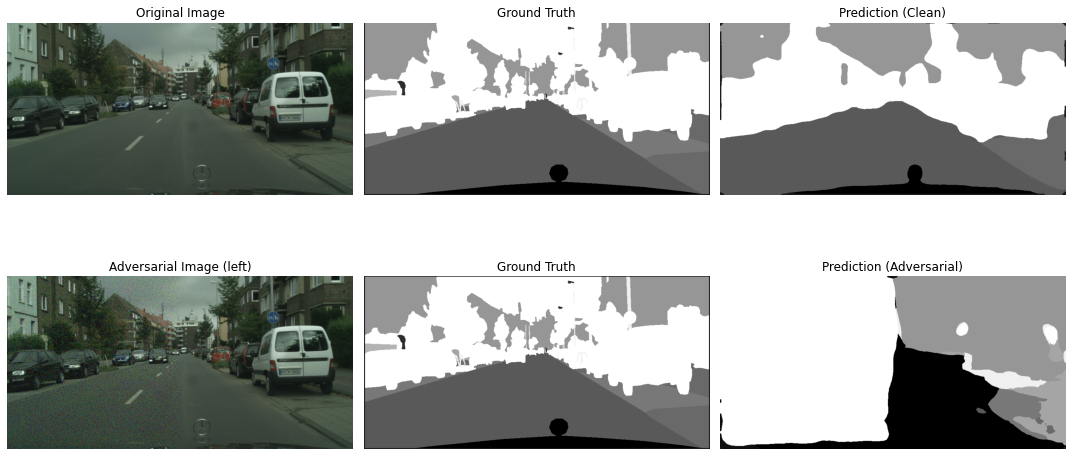

Visualization done.

Running evaluation on 500 batches with region='right', eps=0.1...
[0] Clean IoU: 0.8131, Adv IoU: 0.3263
[100] Clean IoU: 0.8967, Adv IoU: 0.2602
[200] Clean IoU: 0.7234, Adv IoU: 0.3754
[300] Clean IoU: 0.7769, Adv IoU: 0.2566
[400] Clean IoU: 0.8821, Adv IoU: 0.4501
Saved metrics to /kaggle/working/crat_results.json

Regular — region=right | Clean mIoU: 0.7966 | Adv mIoU: 0.3039
Visualizing attack region: right...


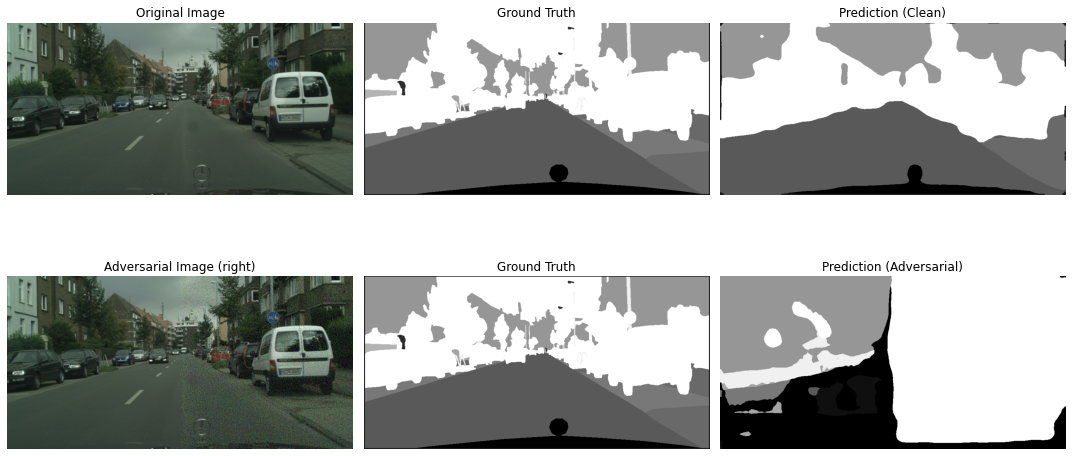

Visualization done.

Running evaluation on 500 batches with region='center', eps=0.1...
[0] Clean IoU: 0.8131, Adv IoU: 0.3625
[100] Clean IoU: 0.8967, Adv IoU: 0.3092
[200] Clean IoU: 0.7234, Adv IoU: 0.2457
[300] Clean IoU: 0.7769, Adv IoU: 0.2458
[400] Clean IoU: 0.8821, Adv IoU: 0.2993
Saved metrics to /kaggle/working/crat_results.json

Regular — region=center | Clean mIoU: 0.7966 | Adv mIoU: 0.3055
Visualizing attack region: center...


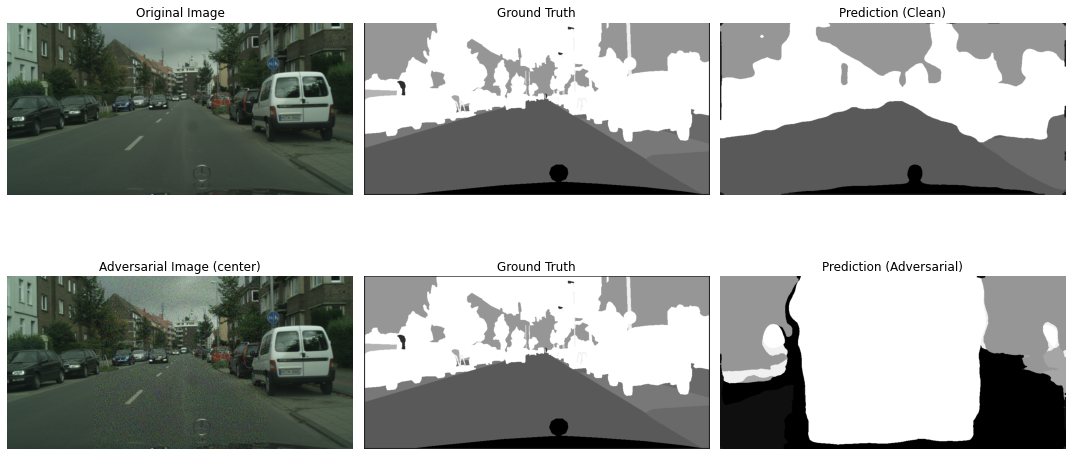

Visualization done.

Running evaluation on 500 batches with region='full', eps=0.1...
[0] Clean IoU: 0.8131, Adv IoU: 0.4084
[100] Clean IoU: 0.8967, Adv IoU: 0.1273
[200] Clean IoU: 0.7234, Adv IoU: 0.2452
[300] Clean IoU: 0.7769, Adv IoU: 0.2802
[400] Clean IoU: 0.8821, Adv IoU: 0.2542
Saved metrics to /kaggle/working/crat_results.json

Regular — region=full | Clean mIoU: 0.7966 | Adv mIoU: 0.2972
Visualizing attack region: full...


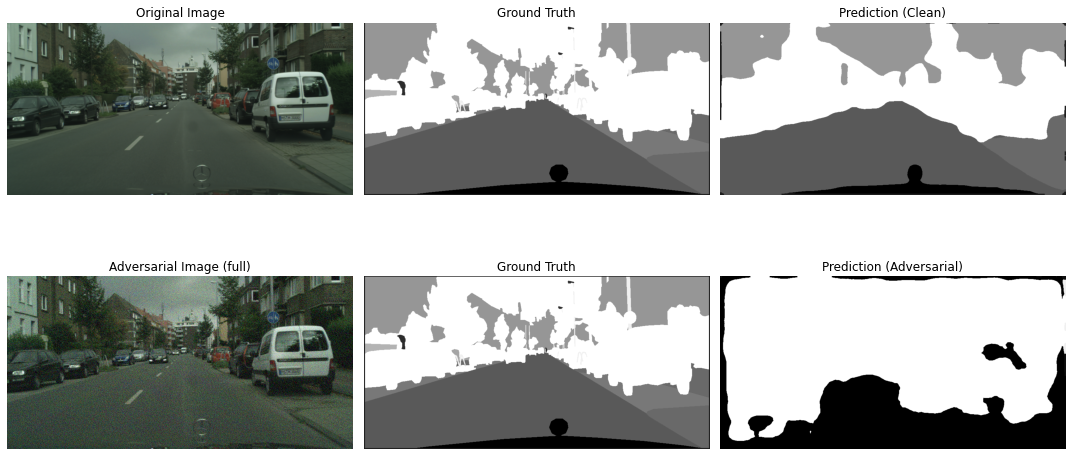

Visualization done.

Running evaluation on 500 batches with region='left', eps=0.0...
[0] Clean IoU: 0.8131, Adv IoU: 0.8131
[100] Clean IoU: 0.8967, Adv IoU: 0.8967
[200] Clean IoU: 0.7234, Adv IoU: 0.7234
[300] Clean IoU: 0.7769, Adv IoU: 0.7769
[400] Clean IoU: 0.8821, Adv IoU: 0.8821
Saved metrics to /kaggle/working/crat_results.json

Regular — region=left | Clean mIoU: 0.7966 | Adv mIoU: 0.7966
Visualizing attack region: left...


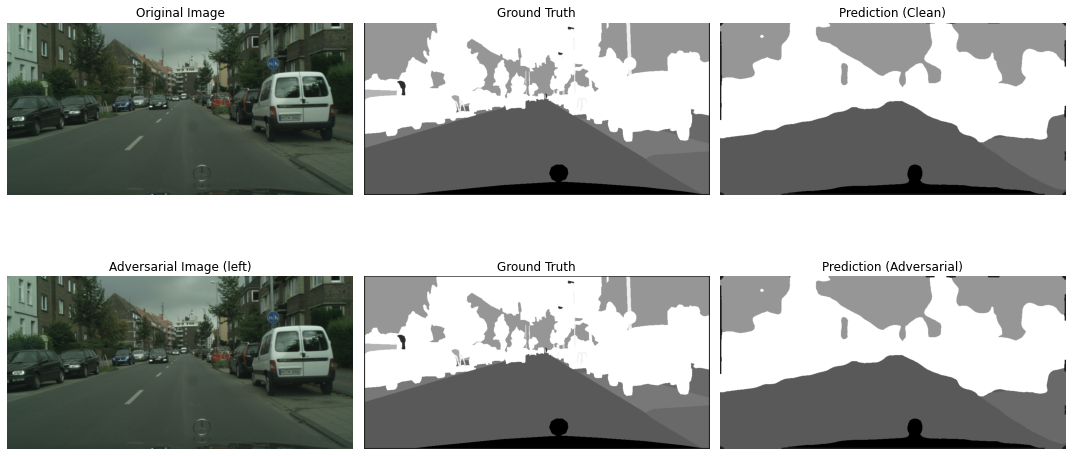

Visualization done.

Running evaluation on 500 batches with region='right', eps=0.0...
[0] Clean IoU: 0.8131, Adv IoU: 0.8131
[100] Clean IoU: 0.8967, Adv IoU: 0.8967
[200] Clean IoU: 0.7234, Adv IoU: 0.7234
[300] Clean IoU: 0.7769, Adv IoU: 0.7769
[400] Clean IoU: 0.8821, Adv IoU: 0.8821
Saved metrics to /kaggle/working/crat_results.json

Regular — region=right | Clean mIoU: 0.7966 | Adv mIoU: 0.7966
Visualizing attack region: right...


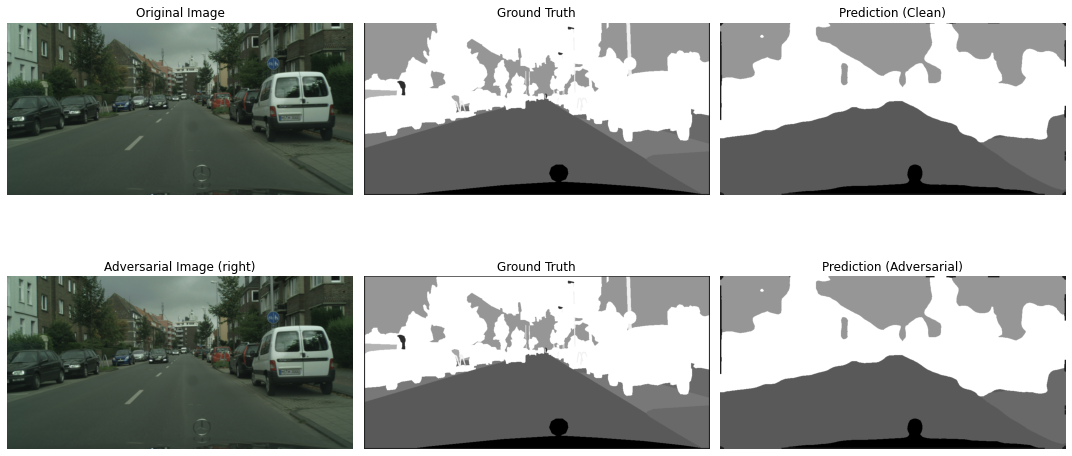

Visualization done.

Running evaluation on 500 batches with region='center', eps=0.0...
[0] Clean IoU: 0.8131, Adv IoU: 0.8131
[100] Clean IoU: 0.8967, Adv IoU: 0.8967
[200] Clean IoU: 0.7234, Adv IoU: 0.7234
[300] Clean IoU: 0.7769, Adv IoU: 0.7769
[400] Clean IoU: 0.8821, Adv IoU: 0.8821
Saved metrics to /kaggle/working/crat_results.json

Regular — region=center | Clean mIoU: 0.7966 | Adv mIoU: 0.7966
Visualizing attack region: center...


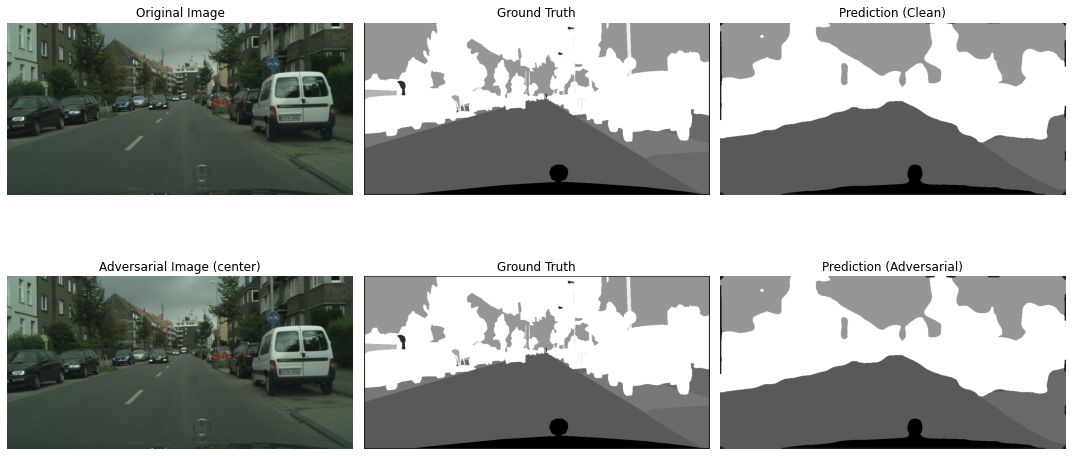

Visualization done.

Running evaluation on 500 batches with region='full', eps=0.0...
[0] Clean IoU: 0.8131, Adv IoU: 0.8131
[100] Clean IoU: 0.8967, Adv IoU: 0.8967
[200] Clean IoU: 0.7234, Adv IoU: 0.7234
[300] Clean IoU: 0.7769, Adv IoU: 0.7769
[400] Clean IoU: 0.8821, Adv IoU: 0.8821
Saved metrics to /kaggle/working/crat_results.json

Regular — region=full | Clean mIoU: 0.7966 | Adv mIoU: 0.7966
Visualizing attack region: full...


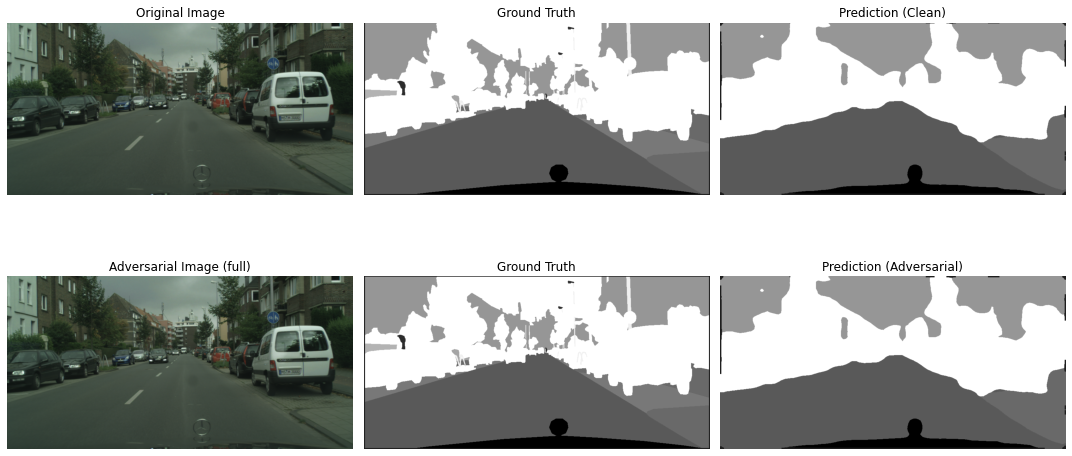

Visualization done.


In [ ]:
# -- Attack evals (epsilon=0.1) --
for region in ["left", "right", "center", "full"]:
    evaluate_model_and_log("Regular", model, valloader, epsilon=0.1, region=region)
    visualize_results(model, valloader, epsilon=0.1, region=region)

# -- Clean-only evals (epsilon=0.0) --
for region in ["left", "right", "center", "full"]:
    evaluate_model_and_log("Regular", model, valloader, epsilon=0.0, region=region)
    visualize_results(model, valloader, epsilon=0.0, region=region)


# GRAM-CAM Call

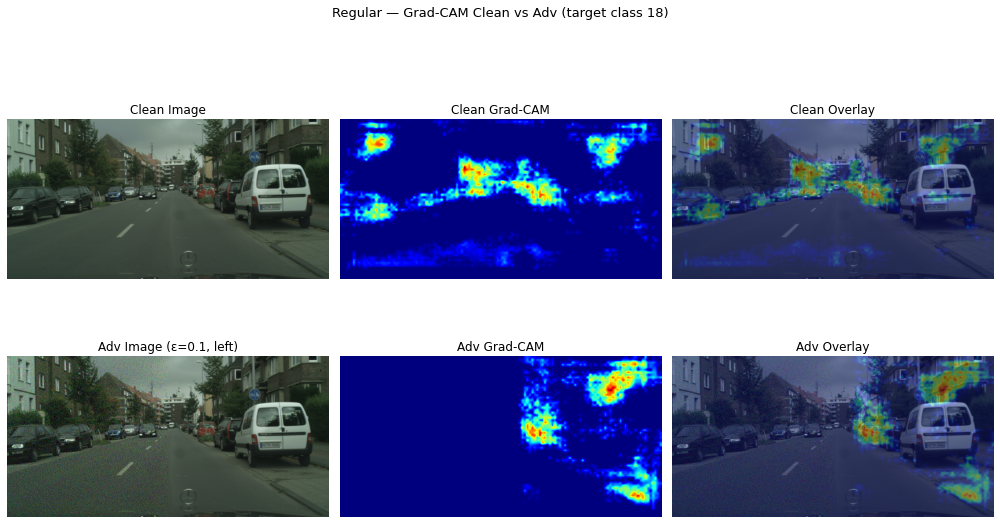

Saved Grad‑CAM figure to: /kaggle/working/gradcam_regular_left.png


In [ ]:
gradcam_clean_vs_adv(model, valloader, epsilon=0.1, region="left", title_prefix="Regular")

In [ ]:
#without_Attack
gradcam_clean_vs_adv(model, valloader, epsilon=0.0, region="left", title_prefix="Regular")

Running evaluation on 500 batches with region='center'...
[0] Clean IoU: 0.8447, Adv IoU: 0.5838
[100] Clean IoU: 0.8844, Adv IoU: 0.4637
[200] Clean IoU: 0.6737, Adv IoU: 0.4770
[300] Clean IoU: 0.8287, Adv IoU: 0.7096
[400] Clean IoU: 0.8702, Adv IoU: 0.5653

Evaluation Summary (on 500 samples)
Avg Clean mIoU: 0.7923
Avg Adv   mIoU: 0.5652
Visualizing attack region: center...


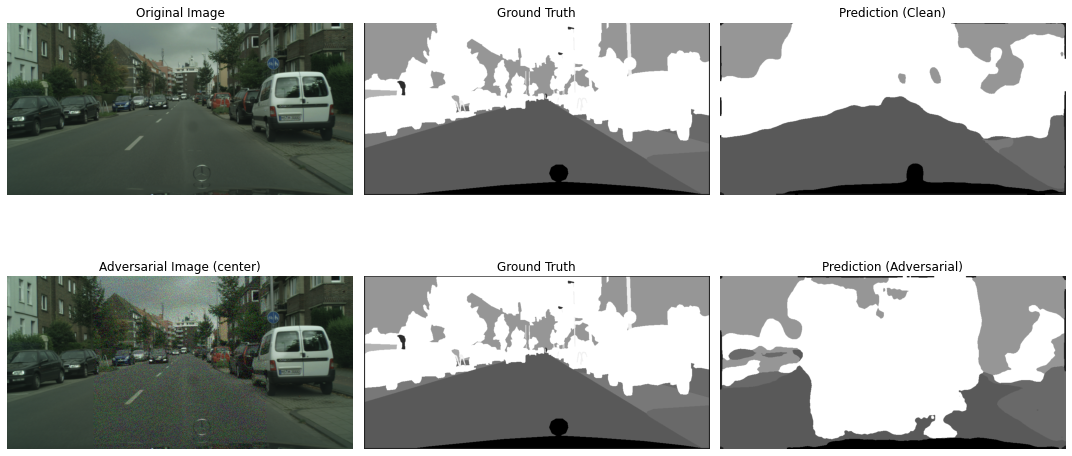

Visualization done.


In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.1, region="center")
visualize_results(model, valloader, epsilon=0.1, region="center")


In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.1, region="left")
visualize_results(model, valloader, epsilon=0.1, region="left")


In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.1, region="right")
visualize_results(model, valloader, epsilon=0.1, region="right")


In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.1, region="full")
visualize_results(model, valloader, epsilon=0.1, region="full")


# Grad-Cam Call

In [ ]:
# Get a sample image and label
images, labels = next(iter(valloader))
image = images[0].to(device).unsqueeze(0)     # [1, 3, H, W]
label = labels[0].to(device).unsqueeze(0)     # [1, H, W]

# Clean Grad-CAM
heatmap_clean = compute_gradcam(model, image)
show_gradcam_heatmap(image[0], heatmap_clean, title="Grad-CAM (Clean Input)")

# Adversarial Grad-CAM (center attack example)
adv_image = fgsm_attack(model, image, label, epsilon=0.1, region="center")
heatmap_adv = compute_gradcam(model, adv_image)
show_gradcam_heatmap(adv_image[0], heatmap_adv, title="Grad-CAM (Adversarial - Center Attack)")


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

# Without Attack-Regular Training

Running evaluation on 500 batches with region='center'...
[0] Clean IoU: 0.8447, Adv IoU: 0.8447
[100] Clean IoU: 0.8844, Adv IoU: 0.8844
[200] Clean IoU: 0.6737, Adv IoU: 0.6737
[300] Clean IoU: 0.8287, Adv IoU: 0.8287
[400] Clean IoU: 0.8702, Adv IoU: 0.8702

Evaluation Summary (on 500 samples)
Avg Clean mIoU: 0.7923
Avg Adv   mIoU: 0.7923
Visualizing attack region: center...


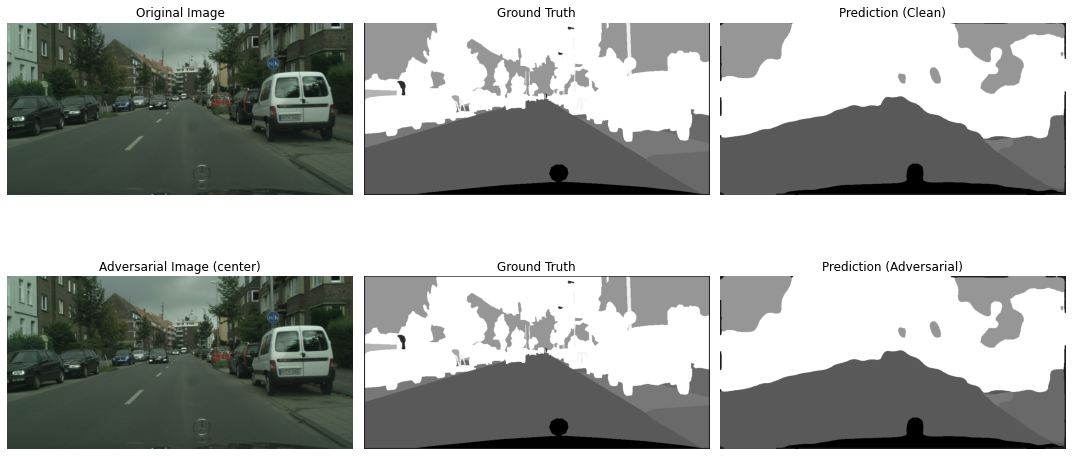

Visualization done.


In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.0, region="center")
visualize_results(model, valloader, epsilon=0.0, region="center")


In [ ]:
print("Image shape:", image.shape)
print("Label shape:", label.shape)


# Smoothed Cross-Entropy Helper

In [ ]:
def cross_entropy_label_smoothing(preds, targets, smoothing=0.1):
    num_classes = preds.shape[1]
    with torch.no_grad():
        true_dist = torch.zeros_like(preds)
        true_dist.fill_(smoothing / (num_classes - 1))
        true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - smoothing)
    return torch.mean(torch.sum(-true_dist * F.log_softmax(preds, dim=1), dim=1))


# Training Function: train_model_label_smoothing()

In [ ]:
def train_model_label_smoothing(model, trainloader, epochs=5, smoothing=0.1, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0.0
        optimizer.zero_grad()
        print(f"\nEpoch {epoch + 1}/{epochs} (Label Smoothing: {smoothing})")

        for step, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)['out']
            loss = cross_entropy_label_smoothing(outputs, labels, smoothing=smoothing)

            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

            if (step + 1) % 100 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

            torch.cuda.empty_cache()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch + 1} complete. Avg Loss: {avg_loss:.4f}")


In [ ]:
model = deeplabv3_resnet50(pretrained=False, pretrained_backbone=False, num_classes=19).to(device)
train_model_label_smoothing(model, trainloader, epochs=1, smoothing=0.1)
# evaluate_model(model, valloader, epsilon=0.1)
# visualize_results(model, valloader, epsilon=0.1)


In [ ]:
evaluate_model(model, valloader, epsilon=0.1, region="center")
visualize_results(model, valloader, epsilon=0.1, region="center")


NameError: name 'evaluate_model' is not defined

# Without attack-Smooth

In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.0, region="center")
visualize_results(model, valloader, epsilon=0.0, region="center")


# Grad-Cam_Call

In [ ]:
# Pick one batch of images
images, labels = next(iter(valloader))
image = images[0].to(device)

# Clean Grad-CAM
heatmap_clean = compute_gradcam(model, image)
show_gradcam_heatmap(image.cpu(), heatmap_clean, title="Grad-CAM (Clean Input)")

# Adversarial image (FGSM)
adv_image = fgsm_attack(model, image.unsqueeze(0), labels[0].unsqueeze(0), epsilon=0.1, region="center")[0]
heatmap_adv = compute_gradcam(model, adv_image)
show_gradcam_heatmap(adv_image.cpu(), heatmap_adv, title="Grad-CAM (Adversarial Input)")


# Block 9: CutMix for Segmentation

9.1 CutMix Helper Function

In [ ]:
import random

def cutmix_data(images, labels, alpha=1.0):
    '''Returns mixed images and pixel-wise mixed labels'''
    lam = np.random.beta(alpha, alpha)
    batch_size, _, H, W = images.size()

    index = torch.randperm(batch_size).to(images.device)

    cx = np.random.randint(W)
    cy = np.random.randint(H)
    cut_w = int(W * np.sqrt(1 - lam))
    cut_h = int(H * np.sqrt(1 - lam))

    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    # Replace patch from another image
    images[:, :, y1:y2, x1:x2] = images[index, :, y1:y2, x1:x2]
    labels[:, y1:y2, x1:x2] = labels[index, y1:y2, x1:x2]

    return images, labels


 9.2 CutMix Training Loop

In [ ]:
def train_model_cutmix(model, trainloader, epochs=5, alpha=1.0, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0.0
        optimizer.zero_grad()
        print(f"\nEpoch {epoch + 1}/{epochs} (CutMix Training)")

        for step, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device).long()

            images, labels = cutmix_data(images, labels, alpha=alpha)

            outputs = model(images)['out']
            loss = F.cross_entropy(outputs, labels)

            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

            if (step + 1) % 100 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

            torch.cuda.empty_cache()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch + 1} complete. Avg Loss: {avg_loss:.4f}")


9.3 Execution Cell

In [ ]:
model = deeplabv3_resnet50(pretrained=False, pretrained_backbone=False, num_classes=19).to(device)

train_model_cutmix(model, trainloader, epochs=1)
# evaluate_model(model, valloader, epsilon=0.1)
# visualize_results(model, valloader, epsilon=0.1)


In [ ]:
evaluate_model(model, valloader, epsilon=0.1, region="center")
visualize_results(model, valloader, epsilon=0.1, region="center")


# Without attack-Cutmix

In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.0, region="center")
visualize_results(model, valloader, epsilon=0.0, region="center")


# Final Execution Block (Block 10):

In [ ]:
train_model(model, trainloader, epochs=1, epsilon=0.1, lambda_mse=0.5, lambda_channel=0.1)


In [ ]:
# evaluate_model(model, valloader, epsilon=0.1)
# visualize_results(model, valloader, epsilon=0.1)

In [ ]:
evaluate_model(model, valloader, epsilon=0.1, region="center")
visualize_results(model, valloader, epsilon=0.1, region="center")


# Without Attack-CRAT

In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.0, region="center")
visualize_results(model, valloader, epsilon=0.0, region="center")


# Block 9.1 — BlurPool Helper + BottleneckWithBlur

In [ ]:
class BottleneckWithBlur(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_blur=False):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # If using blur, set conv2 to stride=1, and blur will handle stride
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1 if use_blur else stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.use_blur = use_blur

        # Blur applied only to main branch, NOT identity branch!
        self.blur = BlurPool(planes * self.expansion) if use_blur and stride == 2 else nn.Identity()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.blur(out)         # ↓ Apply blur + downsampling here
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)  # No blur here!

        out += identity
        out = self.relu(out)
        return out


# For Left

In [ ]:
# ----------- Minimal BlurPool Layer -----------
class BlurPool(nn.Module):
    def __init__(self, channels, filt_size=3):
        super().__init__()
        pad = (filt_size - 1) // 2
        filt = torch.tensor([1., 2., 1.])
        filt = filt[:, None] * filt[None, :]
        filt = filt / filt.sum()
        filt = filt[None, None, :, :].repeat(channels, 1, 1, 1)
        self.register_buffer("filt", filt)
        self.pad = nn.ReflectionPad2d(pad)

    def forward(self, x):
        return F.conv2d(self.pad(x), self.filt, stride=2, groups=x.shape[1])

# ----------- BottleneckWithBlur (uses BlurPool above) -----------
class BottleneckWithBlur(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_blur=False):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1 if use_blur else stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.use_blur = use_blur
        self.blur = BlurPool(planes * self.expansion) if use_blur and stride == 2 else nn.Identity()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.blur(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


# Block 9.2: a custom ResNet50BlurPoolBackbone

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResNet50BlurPoolBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=False)

        self.inplanes = 64
        self.stem = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            BlurPool(channels=64)
        )

        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2, use_blur=True)
        self.layer3 = self._make_layer(256, 6, stride=2, use_blur=True)
        self.layer4 = self._make_layer(512, 3, stride=2, use_blur=True)

    def _make_layer(self, planes, blocks, stride=1, use_blur=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * BottleneckWithBlur.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * BottleneckWithBlur.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * BottleneckWithBlur.expansion),
                BlurPool(planes * BottleneckWithBlur.expansion) if use_blur else nn.Identity()
            )

        layers = []
        layers.append(BottleneckWithBlur(self.inplanes, planes, stride, downsample, use_blur=use_blur))
        self.inplanes = planes * BottleneckWithBlur.expansion
        for _ in range(1, blocks):
            layers.append(BottleneckWithBlur(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

print("✅ Block 9.2 updated: ResNet50BlurPoolBackbone ready.")


# Block 9.3 — DeepLabV3 with BlurPool Backbone

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

# ----------- DeepLabV3 Model using Custom BlurPool ResNet Backbone -----------
class DeepLabV3BlurPool(nn.Module):
    def __init__(self, num_classes=19):
        super().__init__()
        self.backbone = ResNet50BlurPoolBackbone()  # ← From Block 9.2
        self.classifier = DeepLabHead(2048, num_classes)  # DeepLab expects 2048-dim feature map

    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.backbone(x)                        # Pass through modified BlurPool ResNet
        x = self.classifier(x)                      # Apply DeepLabV3 head
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return {"out": x}


#Block 9.4: train_model_blurpool()

In [ ]:
# ----------- Block 10.3: BlurPool Training Loop -----------
def train_model_blurpool(model, trainloader, epochs=1, accum_steps=4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0.0
        optimizer.zero_grad()
        print(f"\nEpoch {epoch + 1}/{epochs} (BlurPool Training)")

        for step, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)['out']
            loss = F.cross_entropy(outputs, labels)
            loss.backward()

            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item()

            if (step + 1) % 100 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.4f}")

            torch.cuda.empty_cache()

        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch + 1} complete. Avg Loss: {avg_loss:.4f}")


In [ ]:
model = DeepLabV3BlurPool(num_classes=19).to(device)
train_model_blurpool(model, trainloader, epochs=1)
# evaluate_model(model, valloader, epsilon=0.1)
# visualize_results(model, valloader, epsilon=0.1)


In [ ]:
evaluate_model(model, valloader, epsilon=0.1, region="center")
visualize_results(model, valloader, epsilon=0.1, region="center")


# Without attack-Blurpool

In [ ]:
# Re-run evaluation + visualization with correct region
evaluate_model(model, valloader, epsilon=0.0, region="center")
visualize_results(model, valloader, epsilon=0.0, region="center")


# Grad-CAM Visualization

In [ ]:
# Get a sample image and label
images, labels = next(iter(valloader))
image = images[0].to(device).unsqueeze(0)     # [1, 3, H, W]
label = labels[0].to(device).unsqueeze(0)     # [1, H, W]

# Clean Grad-CAM
heatmap_clean = compute_gradcam(model, image)
show_gradcam_heatmap(image[0], heatmap_clean, title="Grad-CAM (Clean Input)")

# Adversarial Grad-CAM (center attack example)
adv_image = fgsm_attack(model, image, label, epsilon=0.1, region="center")
heatmap_adv = compute_gradcam(model, adv_image)
show_gradcam_heatmap(adv_image[0], heatmap_adv, title="Grad-CAM (Adversarial - Center Attack)")


In [ ]:
torch.save(model.state_dict(), "/kaggle/working/crat_model.pth")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/crat_model.pth"))
model.eval()


# Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_from_store(results, regions=("full","left","right","center"),
                            models=("Regular","Label Smoothing","CutMix","BlurPool","CRAT")):
    # build arrays in model order
    clean = []
    adv   = []
    for m in models:
        clean.append([results[m]['clean'].get(r, np.nan) for r in regions])
        adv.append([results[m]['adv'].get(r, np.nan) for r in regions])

    clean = np.array(clean)  # [M, R]
    adv   = np.array(adv)

    x = np.arange(len(regions))
    bar_w = 0.15

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Clean
    for i, m in enumerate(models):
        axes[0].bar(x + i*bar_w, clean[i], width=bar_w, label=m)
    axes[0].set_title("Clean mIoU by Region")
    axes[0].set_xticks(x + bar_w*(len(models)-1)/2)
    axes[0].set_xticklabels([r.capitalize() for r in regions])
    axes[0].set_ylim(0, 1.0)
    axes[0].set_ylabel("mIoU")
    axes[0].legend()

    # Adv
    for i, m in enumerate(models):
        axes[1].bar(x + i*bar_w, adv[i], width=bar_w, label=m)
    axes[1].set_title("Adversarial mIoU by Region (ε=0.1)")
    axes[1].set_xticks(x + bar_w*(len(models)-1)/2)
    axes[1].set_xticklabels([r.capitalize() for r in regions])
    axes[1].set_ylim(0, 1.0)
    axes[1].set_ylabel("mIoU")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig("/kaggle/working/miou_by_region.png", dpi=150)
    plt.show()
    print("Saved /kaggle/working/miou_by_region.png")

plot_results_from_store(RESULTS)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and mIoU values
models = ['Regular', 'Label Smoothing', 'CutMix', 'BlurPool', 'CRAT']
clean_miou = [0.7941, 0.8035, 0.8036, 0.7683, 0.7791]
adv_miou   = [0.3595, 0.1341, 0.1120, 0.3180, 0.6998]

x = np.arange(len(models))
width = 0.35

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, clean_miou, width, label='Clean mIoU', color='skyblue')
bars2 = ax.bar(x + width/2, adv_miou, width, label='Adv mIoU', color='salmon')

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

# Formatting
ax.set_xlabel('Model Variant')
ax.set_ylabel('Mean IoU')
ax.set_title('Model Robustness: Clean vs. Adversarial mIoU')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
